# Report on worksheet data and log data
This notebook reports different statistics and visuals on worksheet data and how it relates to log data

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import mannwhitneyu
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 7, 4
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

## Preparing the data
First we load the data generated by the cvs_skills_detector.ipynb
and the worksheet data

Here is what the data looks like:

In [4]:
table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')
graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')

In [5]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
graph_cvs_df['activity order'] = graph_cvs_df.studentid.apply(lambda sid: order[sid])
table_cvs_df['activity order'] = table_cvs_df.studentid.apply(lambda sid: order[sid])

In [6]:
graph_cvs_df = graph_cvs_df.replace(to_replace=2,value=0)
table_cvs_df = table_cvs_df.replace(to_replace=2,value=0)

In [7]:

variables = ["Battery voltage","Area","Separation","Wavelength","Width","Concentration"]

def binarize(number):
    if number>0 : return 1
    else: return 0

graph_cvs_df2 = graph_cvs_df.copy()
for v in variables:
    graph_cvs_df2[v] = graph_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

table_cvs_df2 = table_cvs_df.copy()
for v in variables:
    table_cvs_df2[v] = table_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

graph_cvs_df2['sum'] = graph_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum'] = table_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum caps'] = table_cvs_df2[['Battery voltage','Area','Separation']].sum(axis=1)
table_cvs_df2['sum light absorbance'] = table_cvs_df2[["Wavelength","Width","Concentration"]].sum(axis=1)
graph_cvs_df2['sum caps'] = graph_cvs_df2[['Battery voltage','Area','Separation']].sum(axis=1)
graph_cvs_df2['sum light absorbance'] = graph_cvs_df2[["Wavelength","Width","Concentration"]].sum(axis=1)
table_cvs_df2.head()

,studentid,Battery voltage,Area,Separation,Wavelength,Width,Concentration,activity order,sum,sum caps,sum light absorbance
0,11612162,0,0,0,1,0,1,CL,2,0,2
1,13660166,0,0,0,0,0,1,LC,1,0,1
2,41947147,0,0,0,1,1,1,CL,3,0,3
3,64006159,0,0,0,1,0,1,LC,2,0,2
4,15749160,0,0,1,0,1,1,CL,3,1,2


In [12]:
%reload_ext utils_read_parsing
ids = get_students_to_analyze_log_worksheets('beers')
worksheets = get_worksheet_metadata('beers')
pre = get_pre_worksheet(sim='beers')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main = get_main_worksheet(sim='beers')
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]
print len(ids),len(pre),len(main)

135 135 135


In [9]:
pre['id in logs'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])
main['id in logs'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# Overall, do students learn?
Before we dig into the use of CVS, let's look at how much students learn from pre to post

## Descriptives stats on learning

In [10]:
pre['mean'] = pre[['Concentration','Wavelength','Width']].mean(axis=1)
main['mean'] = main[['Concentration','Wavelength','Width']].mean(axis=1)
pre.head()

,Student ID,Concentration,Wavelength,Width,id in logs,mean
0,10127163,1.0,1.0,1.0,10127163,1.000
1,10232160,1.0,1.0,1.0,10232160,1.000
2,10375160,1.0,1.0,0.0,10537160,0.667
3,10375163,0.0,1.0,1.0,10375163,0.667
4,10420167,1.0,1.0,0.0,10420167,0.667


''

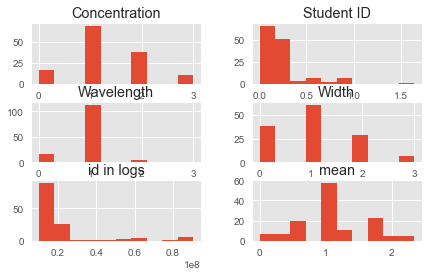

In [11]:
pre.hist()
''

''

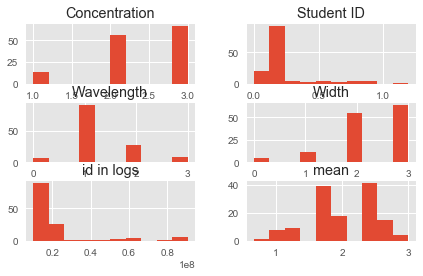

In [12]:
main.hist()
''

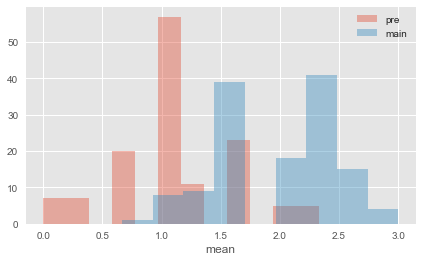

In [13]:
sns.distplot(pre['mean'],kde=False,label='pre')
ax = sns.distplot(main['mean'],kde=False,label='main')
ax.legend()

## Quick comparison test of scores per variable

In [14]:
# print "Mean sample size for each variable, excluding sample sizes of zero by activity order."
p = [['','pre','main',"Mann Whitney U",'p-value']]
for v in ['Concentration','Width','Wavelength','mean']:
    pm = np.mean(pre[v].values)
    ps = np.std(pre[v].values)
    mm = np.mean(main[v].values)
    ms = np.std(main[v].values)
    mann,pv = mannwhitneyu(pre[v].values,main[v].values)
    p.append([v,str(round(pm,2))+' +- '+str(round(ps,2)),str(round(mm,2))+' +- '+str(round(ms,2)),mann,pv])
print tabulate(p)

-------------  ------------  ------------  --------------  -----------------
               pre           main          Mann Whitney U  p-value
Concentration  1.32 +- 0.79  2.39 +- 0.66  3128.5          5.81907726184e-23
Width          1.04 +- 0.84  2.32 +- 0.78  2718.0          2.27512117145e-25
Wavelength     0.92 +- 0.42  1.27 +- 0.65  6631.5          1.18835227783e-07
mean           1.09 +- 0.52  2.0 +- 0.5    2113.5          6.88654315966e-29
-------------  ------------  ------------  --------------  -----------------


## How do students transition from pre to main (scatter-heatmap)

Heatmap of pre by post grades


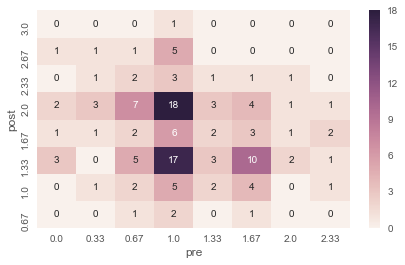

In [15]:
n_bins = max(len(set(pre['mean'].values)),len(set(main['mean'].values)))
heatmap, xedges, yedges = np.histogram2d(pre['mean'], main['mean'], bins=n_bins)
ax= sns.heatmap(heatmap.T,annot=True)
ax.set(xlabel='pre', ylabel='post',xticklabels = sorted([round(x,2) for x in set(pre['mean'])]),yticklabels = sorted([round(x,2) for x in set(main['mean'])]))
print 'Heatmap of pre by post grades'

Overall, yes students learn. Mostly their scores improve for the quantitative variables.

## Finally, a stats model
Followed these blogs for some stats info:
* https://mcfromnz.wordpress.com/2011/03/02/anova-type-iiiiii-ss-explained/
* http://www.statsmodels.org/dev/generated/statsmodels.stats.anova.anova_lm.html
* http://www.marsja.se/three-ways-to-carry-out-2-way-anova-with-python/

First we put everything in one dataframe

In [16]:
scores = pre[['id in logs']]
scores['pre '] = scores['id in logs'].apply(lambda row: pre.loc[pre[pre['id in logs']==row].index[0],'mean'])
scores['main'] = scores['id in logs'].apply(lambda row: main.loc[main[main['id in logs']==row].index[0],'mean'])
order = dict(zip(metadf.index,metadf['activity order']))
scores['order'] = scores['id in logs'].apply(lambda sid: order[sid])

In [17]:
scores.head()

,id in logs,pre,main,order
0,10127163,1.000,2.333,LC
1,10232160,1.000,1.000,LC
2,10537160,0.667,1.000,CL
3,10375163,0.667,1.333,CL
4,10420167,0.667,2.667,CL


In [18]:
import statsmodels.api as sm
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

In [19]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [20]:
formula = 'main ~ pre + C(order) + pre*C(order)'
model = ols(formula, scores).fit()
print "Model: ",formula
# print model.summary()

Model:  main ~ pre + C(order) + pre*C(order)


In [21]:
aov_table = anova_lm(model, typ=1)
eta_squared(aov_table)
omega_squared(aov_table)
print "Using Type 1"
print(aov_table)

Using Type 1
                 df  sum_sq  mean_sq      F  PR(>F)  eta_sq  omega_sq
C(order)        1.0   1.449    1.449  6.222   0.014   0.043     0.036
pre             6.0   2.298    0.383  1.644   0.141   0.068     0.027
pre:C(order)    6.0   1.343    0.224  0.961   0.455   0.040    -0.002
Residual      123.0  28.653    0.233    NaN     NaN     NaN       NaN


In [22]:
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "Using Type 2"
print(aov_table)

Using Type 2
              sum_sq     df      F  PR(>F)  eta_sq  omega_sq
C(order)       1.316    1.0  5.649   0.019   0.039     0.032
pre            2.343    6.0  1.676   0.132   0.070     0.028
pre:C(order)   1.051    6.0  0.752   0.609   0.032    -0.010
Residual      28.653  123.0    NaN     NaN     NaN       NaN


So a high pre doesn't predict a high main score?? Interesting...
Perhaps because the main score really tests their inquiry skills. Possibly prior knowledge neither helped nor hindered the producitivity of the student, only inquiry skills matter???

Order does matter (p < 0.05) and has a small effect size (0.04)

# Score and use of CVS
## First, how many variables do students do CVS on?

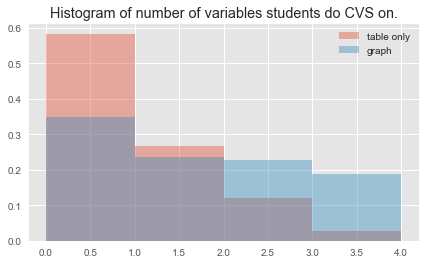

In [23]:
sns.distplot(table_cvs_df2['sum light absorbance']-graph_cvs_df2['sum light absorbance'],kde=False,label='table only',bins=[0,1,2,3,4],norm_hist=True)
ax = sns.distplot(graph_cvs_df2['sum light absorbance'],kde=False,label='graph',bins=[0,1,2,3,4],norm_hist=True)
# ax = sns.distplot(table_cvs_df2['sum light absorbance'],kde=False,label='all table',bins=[0,1,2,3,4],norm_hist=True)
ax.set_title("Histogram of number of variables students do CVS on.")
ax.set_xlabel("")
ax.legend()

When doing CVS on 2 to 3 variables, typically it's done in the graph.

## Are student more likely to do CVS for a variable if they know more about the variable to start with?

''

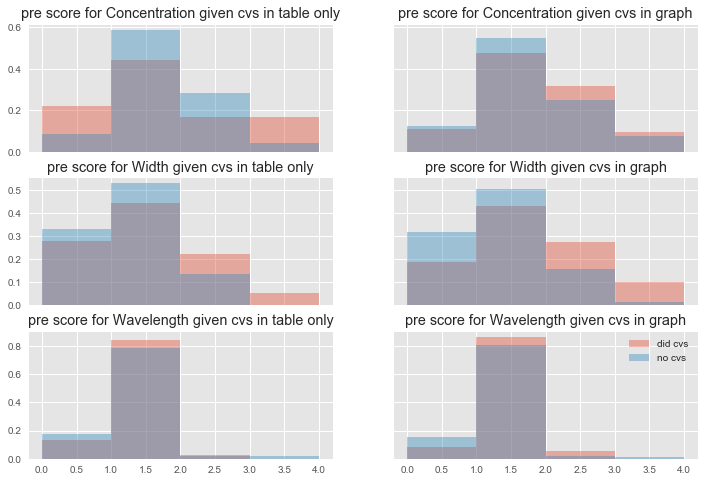

In [24]:
f, axes = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(12,8))
bins = [0,1,2,3,4]
for i in range(3):
    for j in range(2):
        ax = axes[i][j]
        v = ['Concentration','Width','Wavelength'][i]
        t = ['table only','graph'][j]
        if t == 'table only':
            cvs = pre[pre['Student ID'].isin(table_cvs_df2[(table_cvs_df2[v]==1)&(graph_cvs_df2[v]==0)]['studentid'].values)][v]
            nvs = pre[pre['Student ID'].isin(table_cvs_df2[(table_cvs_df2[v]==0)&(graph_cvs_df2[v]==0)]['studentid'].values)][v]
        else:
            cvs = pre[pre['Student ID'].isin(graph_cvs_df2[(graph_cvs_df2[v]==1)]['studentid'].values)][v]
            nvs = pre[pre['Student ID'].isin(graph_cvs_df2[(graph_cvs_df2[v]==0)]['studentid'].values)][v]
        sns.distplot(cvs,bins=bins,kde=False,norm_hist=True,label='did cvs', ax = ax)
        sns.distplot(nvs,bins=bins,kde=False,norm_hist=True,label='no cvs', ax = ax)
        ax.set_title('pre score for '+v+" given cvs in "+t)
        ax.set_xlabel('')
ax.legend()
''

In [25]:
    p = [['','cvs','no cvs',"Mann Whitney U",'p-value'],['--------IN TABLE ONLY--------','','','','']]
    for v in ['Concentration','Width','Wavelength']:
        cvs = pre[pre['Student ID'].isin(table_cvs_df2[(table_cvs_df2[v]==1)&(graph_cvs_df2[v]==0)]['studentid'].values)][v]
        nvs = pre[pre['Student ID'].isin(table_cvs_df2[(table_cvs_df2[v]==0)&(graph_cvs_df2[v]==0)]['studentid'].values)][v]
        mann, pv = mannwhitneyu(cvs,nvs)
        p.append([v,str(round(np.mean(cvs),2))+' +- '+str(round(np.std(cvs),2)),str(round(np.mean(nvs),2))+' +- '+str(round(np.std(nvs),2)),mann,pv])
    p.append(['--------IN GRAPH--------','','','',''])
    for v in ['Concentration','Width','Wavelength']:
        cvs = pre[pre['Student ID'].isin(graph_cvs_df2[graph_cvs_df2[v]==1]['studentid'].values)][v]
        nvs = pre[pre['Student ID'].isin(graph_cvs_df2[graph_cvs_df2[v]==0]['studentid'].values)][v]
        mann, pv = mannwhitneyu(cvs,nvs)
        p.append([v,str(round(np.mean(cvs),2))+' +- '+str(round(np.std(cvs),2)),str(round(np.mean(nvs),2))+' +- '+str(round(np.std(nvs),2)),mann,pv])    
    print tabulate(p)

-----------------------------  ------------  ------------  --------------  ----------------
                               cvs           no cvs        Mann Whitney U  p-value
--------IN TABLE ONLY--------
Concentration                  1.28 +- 0.99  1.28 +- 0.68  395.5           0.383206707226
Width                          1.06 +- 0.85  0.8 +- 0.66   390.5           0.15433423339
Wavelength                     0.89 +- 0.38  0.88 +- 0.51  959.0           0.366066046049
--------IN GRAPH--------
Concentration                  1.4 +- 0.81   1.28 +- 0.78  1850.0          0.192079185225
Width                          1.29 +- 0.89  0.87 +- 0.72  1482.5          0.00354985539995
Wavelength                     0.97 +- 0.37  0.89 +- 0.46  1517.0          0.117002861641
-----------------------------  ------------  ------------  --------------  ----------------


Students with high prior knowledge for width were more likely to do CVS varying width in the graph

## Did CVS help students build better models?

''

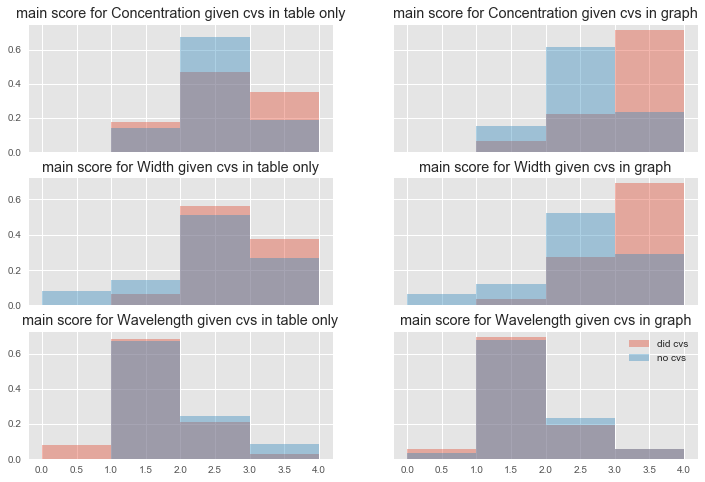

In [26]:
f, axes = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(12,8))
bins = [0,1,2,3,4]
for i in range(3):
    for j in range(2):
        ax = axes[i][j]
        v = ['Concentration','Width','Wavelength'][i]
        t = ['table only','graph'][j]
        if t == 'table only':
            cvs = main[main['Student ID'].isin(table_cvs_df2[(table_cvs_df2[v]==1)&(graph_cvs_df2[v]==0)]['studentid'].values)][v]
            nvs = main[main['Student ID'].isin(table_cvs_df2[(table_cvs_df2[v]==0)&(graph_cvs_df2[v]==0)]['studentid'].values)][v]
        else:
            cvs = main[main['Student ID'].isin(graph_cvs_df2[(graph_cvs_df2[v]==1)]['studentid'].values)][v]
            nvs = main[main['Student ID'].isin(graph_cvs_df2[(graph_cvs_df2[v]==0)]['studentid'].values)][v]
        sns.distplot(cvs,bins=bins,kde=False,norm_hist=True,label='did cvs', ax = ax)
        sns.distplot(nvs,bins=bins,kde=False,norm_hist=True,label='no cvs', ax = ax)
        ax.set_title('main score for '+v+" given cvs in "+t)
        ax.set_xlabel('')
ax.legend()
''

In [27]:
    p = [['','cvs','no cvs',"Mann Whitney U",'p-value'],['--------IN TABLE ONLY--------','','','','']]
    for v in ['Concentration','Width','Wavelength']:
        cvs = main[main['Student ID'].isin(table_cvs_df2[(table_cvs_df2[v]==1)&(graph_cvs_df2[v]==0)]['studentid'].values)][v]
        nvs = main[main['Student ID'].isin(table_cvs_df2[(table_cvs_df2[v]==0)&(graph_cvs_df2[v]==0)]['studentid'].values)][v]
        mann, pv = mannwhitneyu(cvs,nvs)
        p.append([v,str(round(np.mean(cvs),2))+' +- '+str(round(np.std(cvs),2)),str(round(np.mean(nvs),2))+' +- '+str(round(np.std(nvs),2)),mann,pv])
    p.append(['--------IN GRAPH--------','','','',''])
    for v in ['Concentration','Width','Wavelength']:
        cvs = main[main['Student ID'].isin(graph_cvs_df2[graph_cvs_df2[v]==1]['studentid'].values)][v]
        nvs = main[main['Student ID'].isin(graph_cvs_df2[graph_cvs_df2[v]==0]['studentid'].values)][v]
        mann, pv = mannwhitneyu(cvs,nvs)
        p.append([v,str(round(np.mean(cvs),2))+' +- '+str(round(np.std(cvs),2)),str(round(np.mean(nvs),2))+' +- '+str(round(np.std(nvs),2)),mann,pv])    
    print tabulate(p)

-----------------------------  ------------  ------------  --------------  -----------------
                               cvs           no cvs        Mann Whitney U  p-value
--------IN TABLE ONLY--------
Concentration                  2.18 +- 0.71  2.05 +- 0.57  324.0           0.218628015346
Width                          2.31 +- 0.58  1.96 +- 0.86  310.0           0.0865489982905
Wavelength                     1.18 +- 0.6   1.41 +- 0.64  788.0           0.0689841361226
--------IN GRAPH--------
Concentration                  2.65 +- 0.6   2.08 +- 0.61  992.0           2.53812834774e-07
Width                          2.66 +- 0.54  2.05 +- 0.81  1070.0          2.65992328596e-06
Wavelength                     1.25 +- 0.64  1.31 +- 0.63  1488.5          0.30061620369
-----------------------------  ------------  ------------  --------------  -----------------


Clearly, doing CVS increases the score for that variable by at over half a point. Now we still have to fix this data set since we should only look at students who used a table or a graph? Also would be good to compare students who only did table to student who did graph and then compare those.

# The order effect
## Modeling concentration score

In [28]:
scores_c = main[['id in logs']]
scores_c['pre_concentration'] = scores_c['id in logs'].apply(lambda row: pre.loc[pre[pre['id in logs']==row].index[0],'Concentration'])
scores_c['main_concentration'] = scores_c['id in logs'].apply(lambda row: main.loc[main[main['id in logs']==row].index[0],'Concentration'])
scores_c['order'] = scores_c['id in logs'].apply(lambda sid: order[sid])
scores_c['cvs_table'] = scores_c['id in logs'].apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row].index[0],'Concentration'])
scores_c['cvs_graph'] = scores_c['id in logs'].apply(lambda row: graph_cvs_df2.loc[graph_cvs_df2[graph_cvs_df2['studentid']==row].index[0],'Concentration'])
scores_c['cvs_table_only'] = scores_c['cvs_table'] - scores_c['cvs_graph']

In [29]:
formula = 'main_concentration ~ pre_concentration + C(order) + C(cvs_table_only) + C(cvs_graph) + C(order)*C(cvs_table_only) + C(order)*C(cvs_graph)'
model = ols(formula, scores_c).fit()
print "Model: ",formula
print model.summary()

Model:  main_concentration ~ pre_concentration + C(order) + C(cvs_table_only) + C(cvs_graph) + C(order)*C(cvs_table_only) + C(order)*C(cvs_graph)
                            OLS Regression Results                            
Dep. Variable:     main_concentration   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     7.920
Date:                Fri, 15 Dec 2017   Prob (F-statistic):           2.86e-07
Time:                        15:42:51   Log-Likelihood:                -113.44
No. Observations:                 135   AIC:                             240.9
Df Residuals:                     128   BIC:                             261.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                            coef    std err     

In [30]:
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "Using Type 2"
print(aov_table)

Using Type 2
                            sum_sq     df       F     PR(>F)     eta_sq  omega_sq
C(order)                     2.195    1.0   6.621  1.122e-02  3.890e-02     0.033
C(cvs_table_only)            0.437    1.0   1.317  2.533e-01  7.737e-03     0.002
C(cvs_graph)                 9.431    1.0  28.447  4.224e-07  1.671e-01     0.160
C(order):C(cvs_table_only)   0.454    1.0   1.368  2.443e-01  8.038e-03     0.002
C(order):C(cvs_graph)        0.026    1.0   0.078  7.810e-01  4.560e-04    -0.005
pre_concentration            1.446    1.0   4.361  3.874e-02  2.563e-02     0.020
Residual                    42.437  128.0     NaN        NaN        NaN       NaN


## Modeling width score

In [31]:
scores_w = main[['id in logs']]
scores_w['pre_width'] = scores_w['id in logs'].apply(lambda row: pre.loc[pre[pre['id in logs']==row].index[0],'Width'])
scores_w['main_width'] = scores_w['id in logs'].apply(lambda row: main.loc[main[main['id in logs']==row].index[0],'Width'])
scores_w['order'] = scores_w['id in logs'].apply(lambda sid: order[sid])
scores_w['cvs_table'] = scores_w['id in logs'].apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row].index[0],'Width'])
scores_w['cvs_graph'] = scores_w['id in logs'].apply(lambda row: graph_cvs_df2.loc[graph_cvs_df2[graph_cvs_df2['studentid']==row].index[0],'Width'])
scores_w['cvs_table_only'] = scores_w['cvs_table'] - scores_w['cvs_graph']

In [32]:
formula = 'main_width ~ pre_width + C(order) + C(cvs_table_only) + C(cvs_graph) + C(order)*C(cvs_table_only) + C(order)*C(cvs_graph)'
model = ols(formula, scores_w).fit()
print "Model: ",formula
print model.summary()

Model:  main_width ~ pre_width + C(order) + C(cvs_table_only) + C(cvs_graph) + C(order)*C(cvs_table_only) + C(order)*C(cvs_graph)
                            OLS Regression Results                            
Dep. Variable:             main_width   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     6.686
Date:                Fri, 15 Dec 2017   Prob (F-statistic):           3.56e-06
Time:                        15:42:52   Log-Likelihood:                -138.93
No. Observations:                 135   AIC:                             291.9
Df Residuals:                     128   BIC:                             312.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t

In [33]:
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "Using Type 2"
print(aov_table)

Using Type 2
                            sum_sq     df       F     PR(>F)  eta_sq  omega_sq
C(order)                     0.875    1.0   1.809  1.810e-01   0.011     0.005
C(cvs_table_only)            1.362    1.0   2.817  9.572e-02   0.017     0.011
C(cvs_graph)                12.192    1.0  25.210  1.686e-06   0.153     0.146
C(order):C(cvs_table_only)   1.688    1.0   3.490  6.403e-02   0.021     0.015
C(order):C(cvs_graph)        1.339    1.0   2.768  9.863e-02   0.017     0.011
pre_width                    0.241    1.0   0.498  4.816e-01   0.003    -0.003
Residual                    61.903  128.0     NaN        NaN     NaN       NaN
